In [ ]:
import proposal as pp

pp.InterpolationDef.path_to_tables = "/home/msackel/.local/share/PROPOSAL/"
N_SAMPLES = int(1e4)

In [2]:
args = {
    "particle_def": pp.particle.MuMinusDef(),
    "target": pp.medium.Ice(),
    "interpolate": True,
    "cuts": pp.EnergyCutSettings(500, 0.05, False)
}

cross = pp.crosssection.make_std_crosssection(**args)

In [3]:
collection = pp.PropagationUtilityCollection()
collection.displacement = pp.make_displacement(cross, True)
collection.interaction = pp.make_interaction(cross, True)
collection.time = pp.make_time(cross, args["particle_def"], True)

utility = pp.PropagationUtility(collection = collection)

In [4]:
detector = pp.geometry.Box(pp.Vector3D(0,0,0), 1e7, 1e7, 1e7)
density_distr = pp.medium.density_homogeneous(args["target"].mass_density, 1.0)

prop = pp.Propagator(args["particle_def"], [(detector, utility, density_distr)])

initial_state = pp.particle.DynamicData(args["particle_def"].particle_type)
initial_state.energy = 1e8
initial_state.direction = pp.Vector3D(1,0,0)

In [8]:
from tqdm import tqdm
import numpy as np

STATISTICS = int(1e3)
final_energy = np.empty(STATISTICS)
for i in tqdm(range(STATISTICS)):
    sec = prop.propagate(initial_state, 1e5, 1e3)
    #final_energy[i] = sec[-1]

100%|██████████| 1000/1000 [00:23<00:00, 41.71it/s]


In [10]:
final_energy

array([105.6583745, 105.6583745, 105.6583745, ..., 105.6583745,
       105.6583745, 105.6583745])

In [8]:
6:28 min, cut: 500, 0.05

SyntaxError: invalid syntax (<ipython-input-8-8de6428521d8>, line 1)

<ipython-input-9-57028b8413e0>:6: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


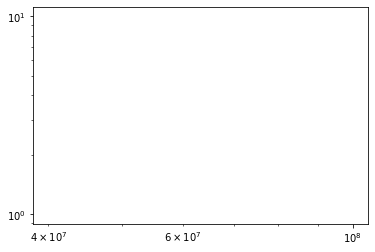

In [9]:
# print(final_energy)
import matplotlib.pyplot as plt
import numpy as np
plt.hist(final_energy, bins = np.geomspace(4e7, 1e8, 100), histtype="step")
plt.xscale("log")
plt.yscale("log")

In [ ]:
print("hello world")